In [1]:
from mpcrl import *
from WindGym import WindFarmEnv
from mpcrl import make_config
from py_wake.examples.data.hornsrev1 import V80
import numpy as np
import matplotlib.pyplot as plt

In [2]:
config = make_config()

env = WindFarmEnv(
    turbine=V80(),  # e.g., IEA37/DTU10MW WT from PyWake
    x_pos=np.array([0, 400, 800]),  # x positions of the turbines
    y_pos=np.array([0, 0, 0]),      # y positions of the turbines
    config=config,
    turbtype="None",
    dt_env=30,
    dt_sim=10,
    yaw_step_sim=10*0.3,  # 10 sim step * 0.3 (yaw actuation time)
    yaw_init='Zeros',
    n_passthrough=30,
    reset_init=0,
    # wd_function=wd_func,
    # backend="pywake",         # <<< switch here
)

obs, info = env.reset(seed=42)

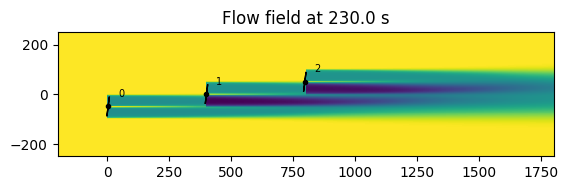

In [3]:
# Plot the inital farm here:
env.plot_farm()

In [4]:
env.wd, env.ws, env.ti, env.current_yaw

(277.1719583982277, 11.547912097111926, 0.05, array([0., 0., 0.]))

In [5]:
# Setup the MPC
D = env.D
x_pos = env.x_pos.copy()
y_pos = env.y_pos.copy()


mpc_model = WindFarmModel(x_pos, y_pos, D=D, cache_size=64000, 
                          wt=env.turbine,
                            cache_quant=0.25, wind_quant=0.25,
                            apply_yaw_penalty=True)

estimated_ws = np.random.uniform(5, 15)
estimated_TI = np.random.uniform(0.00, 0.15)
estimated_wd = 270.0


mpc_model.update_conditions(U_inf=estimated_ws, TI=estimated_TI, wd=estimated_wd)
        


current_yaws_sorted = np.random.uniform(-45, 45, size=(current_yaws_sorted.shape))[mpc_model.sorted_indices]
print("current_yaws_sorted: ", current_yaws_sorted)
print("estimated_ws: ", estimated_ws)
print("estimated_TI: ", estimated_TI)
print("estimated_wd: ", estimated_wd)
# Step 2: optimize the yaw angles

optimized_params = optimize_farm_back2front(
    mpc_model, current_yaws_sorted, 
    r_gamma=0.3, # yaw rate (deg/s)
    t_AH=100.0,  # action horizon (s)
    dt_opt=10.0,  # optimization time step (s)
    T_opt=500.0,  # prediction horizon (s)
    maxfun=50,
    seed=42,
    initial_params=None,
)

NameError: name 'current_yaws_sorted' is not defined

In [56]:
# Setup the MPC
D = env.D
x_pos = env.x_pos.copy()
y_pos = env.y_pos.copy()


mpc_model = WindFarmModel(x_pos, y_pos, D=D, cache_size=64000, 
                          wt=env.turbine,
                            cache_quant=0.25, wind_quant=0.25,
                            apply_yaw_penalty=True)

estimated_ws = 9.408677377662825
estimated_TI = 0.01
estimated_wd = 270.0


mpc_model.update_conditions(U_inf=estimated_ws, TI=estimated_TI, wd=estimated_wd)
        


current_yaws_sorted = np.random.uniform(-45, 45, size=(current_yaws_sorted.shape))[mpc_model.sorted_indices]
print("current_yaws_sorted: ", current_yaws_sorted)
print("estimated_ws: ", estimated_ws)
print("estimated_TI: ", estimated_TI)
print("estimated_wd: ", estimated_wd)
# Step 2: optimize the yaw angles

optimized_params = optimize_farm_back2front(
    mpc_model, current_yaws_sorted, 
    r_gamma=0.3, # yaw rate (deg/s)
    t_AH=100.0,  # action horizon (s)
    dt_opt=10.0,  # optimization time step (s)
    T_opt=500.0,  # prediction horizon (s)
    maxfun=50,
    seed=42,
    initial_params=None,
)

current_yaws_sorted:  [ 17.55425332  25.54672719 -44.96524524]
estimated_ws:  9.408677377662825
estimated_TI:  0.01
estimated_wd:  270.0


/home/marcus/miniconda3/envs/testenv/lib/python3.13/site-packages/py_wake/deficit_models/gaussian.py:519: RuntimeWarning: invalid value encountered in sqrt
  deficit_center_ijlk = a1 - np.sqrt(a2 - ((n * ctx_ijlk) /


ValueError: Stopping algorithm because function create NaN or (+/-) infinity values even with trying new random parameters

In [6]:
from py_wake.literature.gaussian_models import Blondel_Cathelain_2020
from py_wake.turbulence_models import CrespoHernandez
from py_wake.site import UniformSite
from py_wake.deflection_models.jimenez import JimenezWakeDeflection
wt = V80()

In [9]:
site = UniformSite(p_wd=[1.0], ti=0.03)
wfm = Blondel_Cathelain_2020(
    site, wt, 
    turbulenceModel=CrespoHernandez(), 
    deflectionModel=JimenezWakeDeflection()
)
current_yaws_sorted = np.random.uniform(-45, 45, size=(3))

In [14]:
current_yaws_sorted

array([ -2.29801096,  30.17999659, -25.5420194 ])

In [52]:
current_yaws_sorted = np.random.uniform(-45, 45, size=(3))
sim_res = wfm(
                    x=x_pos, y=y_pos, 
                    TI=0.000050,
                    wd=[270], ws=[6], 
                    tilt=0, yaw=current_yaws_sorted
                )

In [15]:
current_yaws_sorted.shape

(3,)

In [11]:

obs, info = env.reset(seed=42)

# Setup the MPC
D = env.D
x_pos = env.x_pos.copy()
y_pos = env.y_pos.copy()

mpc_model = WindFarmModel(x_pos, y_pos, D=D, cache_size=64000, 
                          wt=env.turbine,
                            cache_quant=0.25, wind_quant=0.25,
                            apply_yaw_penalty=True)

current_yaws_orig = env.current_yaw.copy()
history = []

powers_plot = []
yaws_plot = []
time_plot = []

for _ in range(10):

    # Step 1: update the MPC model with the current state
    previous_opt_params = None
    estimated_wd = env.wd
    estimated_ws = env.ws
    estimated_TI = env.ti

    mpc_model.update_conditions(U_inf=estimated_ws, TI=estimated_TI, wd=estimated_wd)

    current_yaws_orig = env.current_yaw.copy()
    current_yaws_sorted = current_yaws_orig[mpc_model.sorted_indices]
    print("current_yaws_sorted: ", current_yaws_sorted)

    # Step 2: optimize the yaw angles

    optimized_params = optimize_farm_back2front(
        mpc_model, current_yaws_sorted, 
        r_gamma=0.3, # yaw rate (deg/s)
        t_AH=100.0,  # action horizon (s)
        dt_opt=10.0,  # optimization time step (s)
        T_opt=500.0,  # prediction horizon (s)
        maxfun=50,
        seed=42,
        initial_params=previous_opt_params
    )

    previous_opt_params = optimized_params.copy()

    dt_mpc = 60 # MPC control interval (s)
    t_action, trajectories, _ = run_farm_delay_loop_optimized(
        mpc_model, optimized_params, current_yaws_sorted, 
        r_gamma=0.3, t_AH=100.0, dt=dt_mpc, T=dt_mpc
    )

    next_yaws_sorted = np.array([traj[-1] for traj in trajectories])
    next_yaws_orig = next_yaws_sorted[mpc_model.unsorted_indices]

    print("next_yaws_orig: ", next_yaws_orig)

    # The action should then be:
    action = (next_yaws_orig - env.yaw_min) / (env.yaw_max - env.yaw_min) * 2 - 1


    # Do the env step:
    obs, reward, terminated, truncated,  info = env.step(action)

    # log for the plot
    powers_plot.append(info["powers"].sum(axis=1))
    time_plot.append(info["time_array"])
    yaws_plot.append(info["yaws"])


current_yaws_sorted:  [0. 0. 0.]
next_yaws_orig:  [12.16538876 10.61498646  0.        ]
current_yaws_sorted:  [9. 9. 0.]
next_yaws_orig:  [10.60379342 10.19258881  0.        ]
current_yaws_sorted:  [10.60379342 10.19258881  0.        ]
next_yaws_orig:  [10.60379342 10.19258881  0.        ]
current_yaws_sorted:  [10.60379342 10.19258881  0.        ]
next_yaws_orig:  [10.60379342 10.19258881  0.        ]
current_yaws_sorted:  [10.60379342 10.19258881  0.        ]
next_yaws_orig:  [10.60379342 10.19258881  0.        ]
current_yaws_sorted:  [10.60379342 10.19258881  0.        ]
next_yaws_orig:  [10.60379342 10.19258881  0.        ]
current_yaws_sorted:  [10.60379342 10.19258881  0.        ]
next_yaws_orig:  [10.60379342 10.19258881  0.        ]
current_yaws_sorted:  [10.60379342 10.19258881  0.        ]
next_yaws_orig:  [10.60379342 10.19258881  0.        ]
current_yaws_sorted:  [10.60379342 10.19258881  0.        ]
next_yaws_orig:  [10.60379342 10.19258881  0.        ]
current_yaws_sorted

In [12]:
time_plot = np.concatenate(time_plot)
powers_plot = np.concatenate(powers_plot)
yaws_plot = np.concatenate(yaws_plot)

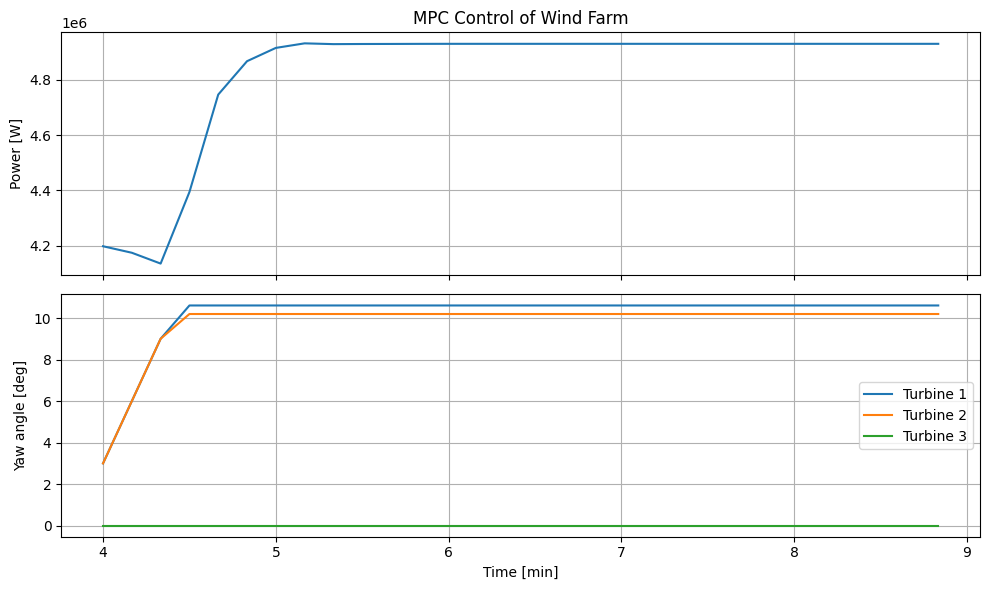

In [13]:
fig, ax = plt.subplots(2,1, figsize=(10,6), sharex=True)

ax[0].plot(time_plot/60, powers_plot)
ax[0].set_ylabel("Power [W]")
ax[0].set_title("MPC Control of Wind Farm")
ax[0].grid()

ax[1].plot(time_plot/60, yaws_plot)
ax[1].set_ylabel("Yaw angle [deg]")
ax[1].set_xlabel("Time [min]")
ax[1].legend([f"Turbine {i+1}" for i in range(yaws_plot.shape[1])])
ax[1].grid()
plt.tight_layout()
plt.show()


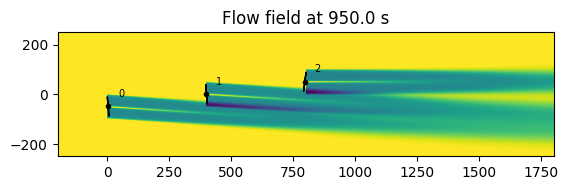

In [13]:
# The farm is now:
env.plot_farm()

In [53]:
%load_ext autoreload
%autoreload 2

In [54]:
from mpcrl import MPCenv, make_config
from py_wake.examples.data.hornsrev1 import V80
import numpy as np
import copy
import matplotlib.pyplot as plt